##### SME0202 Métodos Numéricos em Equações Diferenciais Ordinárias
## Trabalho 2 - Problemas de Valor Inicial - Pêndulo Simples e Duplo
- Cody Stefano Barham Setti - 4856322
- Ian de Holanda Cavalcanti Bezerra - 13835412

#### Importanto Bibliotecas

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import ellipj, ellipk
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings('ignore')

#### Configurando Estilo dos Gráficos

In [50]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 12

### Tarefa 1 - Pêndulo Simples

#### Solução Analítica de Referência

Temos o seguinte PVI:
$$
\begin{cases}
    q^{\prime\prime}(t) + \sin(q(t)) = 0 \\
    q(0) = q_0 \\
    q^\prime(0) = 0
\end{cases}
$$
A solução analítica deste PVI é
$$
    q(t) = 2\arcsin\left\{\sin\left(\tfrac{q_0}{2}\right)\operatorname{sn}\left[K\left({\sin\left(\tfrac{q_0}{2}\right)}^2\right)-t;{\sin\left(\tfrac{q_0}{2}\right)}^2\right]\right\},
$$
onde $\operatorname{sn}(\cdot\,;\cdot)$ denota a função elíptica de Jacobi e $K(\cdot)$ a integral elíptica completa de primeira ordem.

In [51]:
def RefSolution(q_0, t):
    """
    Solução Analítica para o pêndulo simples usando funções elípticas

    Parâmetros:
    q_0: Amplitude inicial (rad - float)
      t: Array de tempo    (s - np.array)

    Retornos:
    q: Posição angular    (rad - float)
    p: Velocidade angular (rad/s - folat)
    """
    # Variáveis auxiliares
    k_0 = np.sin(q_0/2)

    # Integral elíptica completa de primeira ordem
    K = ellipk(k_0**2)

    # Funções elípticas de Jacobi: sn, cn, dn & ph
    sn, cn, _, _ = ellipj(K - t, k_0**2)

    # Posição angular
    q = 2 * np.arcsin(k_0 * sn)

    # Velocidade angular
    dq_dt = -2 * k_0 * cn

    return q, dq_dt

Se definirmos $u_1(t) \coloneqq q(t)$ e $u_2(t) \coloneqq q'(t)$, então, podemos mudar de uma EDO de 2ª ordem para um sistema $2\times2$ de EDOs de primeira ordem, como descrito abaixo:
$$
\begin{cases}
    \begin{bmatrix}u_1(t) \\ u_2(t)\end{bmatrix}' = \begin{bmatrix}u_2(t) \\ \sin(u_1(t))\end{bmatrix} \\ \\
    \begin{bmatrix}u_1(0) \\ u_2(0)\end{bmatrix} = \begin{bmatrix}q_0 \\ 0\end{bmatrix}
\end{cases}
\qquad\text{ou, de forma mais enxuta,}\qquad
\begin{cases}
    \boldsymbol{u}'(t) = \boldsymbol{f}(\boldsymbol{u}(t)) \\
    \boldsymbol{u}(0) = \boldsymbol{\eta}
\end{cases}
$$
Note que este sistema é autônomo, isto é, $\boldsymbol{f}$ não depende diretamente de $t$.

In [52]:
def pendulum_system(u):
    """
    Representação do pêndulo simples como sistema de EDOs de 1ª ordem
    u = [p, q], onde q é a posição angular (rad) e p a velocidade angular (rad/s)
    (dtype[u] = lista contendo dois floats)
    """
    u1, u2 = u 
    du1_dt = u2 
    du2_dt = -np.sin(u1)
    return np.array([du1_dt, du2_dt])

#### Tarefa 1.1 - Implementação dos Métodos de Euler, RK4 (Clássico) e Euler Implícito

Implementação do Método de Euler Explícito

In [53]:
def euler_explicit(f, u0, t_span, h):
    t = np.arange(t_span[0], t_span[1]+h, h)
    n = len(t)
    u = np.zeros((n, len(u0)))
    u[0,:] = u0

    for i in range(n-1):
        u[i+1,:] = u[i,:] + h*f(u[i,:])
    
    return t, u 

Implementação do Método Runge-Kutta de 4ª Ordem Clássico

In [54]:
def rk4(f, u0, t_span, h):
    t = np.arange(t_span[0], t_span[1]+h, h)
    n = len(t)
    u = np.zeros((n, len(u0)))
    u[0,:] = u0
    
    for i in range(n-1):
        k1 = f(u[i,:])
        k2 = f(u[i,:] + 0.5*h*k1)
        k3 = f(u[i,:] + 0.5*h*k2)
        k4 = f(u[i,:] + h*k3)
        u[i+1,:] = u[i,:] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    
    return t, u 

Implementação do Método de Euler Implícito

In [55]:
def euler_implicit(f, u0, t_span, h, tol=1e-10, max_iter=50):
    t = np.arange(t_span[0], t_span[1] + h, h)
    n = len(t)
    u = np.zeros((n, len(u0)))
    u[0,:] = u0
    
    for i in range(n-1):
        # Método de Newto para resolver: u_{n+1} = u_n + h*f(u_{n+1})
        u_guess = u[i,:] + h*f(u[i,:])  # Chute inicial utilizando 'Euler Explícito'
        
        for _ in range(max_iter):
            # Para o pêndulo: f = [p, -sin(q)]
            q_guess, p_guess = u_guess
            
            # Residual: G(u) = u - u_n - h*f(u) = 0
            G = u_guess - u[i] - h*f(u_guess)
            
            # Jacobiano de G: dG/du = I - h*df/du
            # Para o pêndulo: df/du = [[   0   , 1],
            #                          [-cos(q), 0]]
            J = np.array([[        1        , -h],
                          [h*np.cos(q_guess),  1]])
            
            # Atualização de Newton
            delta = np.linalg.solve(J, -G)
            u_guess = u_guess + delta
            
            if np.linalg.norm(delta) < tol:
                break
        
        u[i+1,:] = u_guess
    
    return t, u 

#### Tarefa 1.2 - Evolução Temporal do Pêndulo Simples Segundo os Métodos Numéricos Implementados

Condições iniciais elegidas para o PVI:

In [56]:
q0 = np.pi/4
p0 = 0

Domínio temporal considerado:

In [57]:
t_span = [0, 20]

Discretização da evolução temporal elegida:

In [58]:
h = 0.01

Evoluções temporais do pêndulo simples fornecidas pelos *solvers* `euler_explicit`, `rk4` e `euler_implicit`:

In [59]:
u0 = np.array([q0, p0])

t, u_euler    = euler_explicit(pendulum_system, u0, t_span, h)
t, u_rk4      =            rk4(pendulum_system, u0, t_span, h)
t, u_implicit = euler_implicit(pendulum_system, u0, t_span, h)

# Resgatar solução de referência
q_ref, p_ref = RefSolution(q0, t)

Gráficos fornecidos por cada *solver*

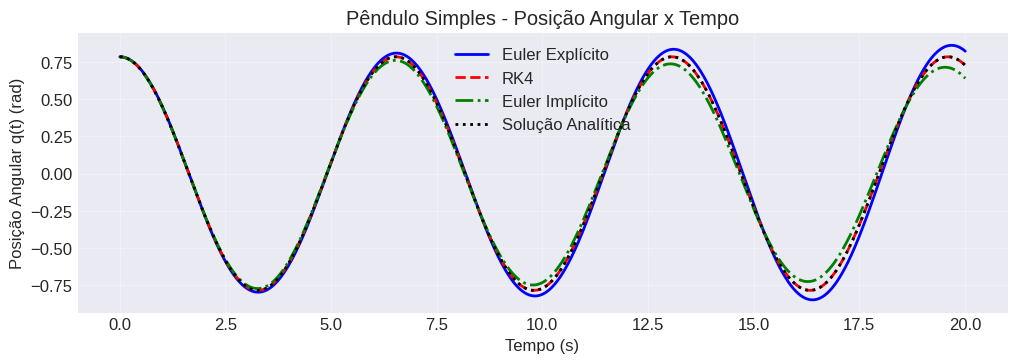

In [60]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, u_euler[:,0]   , 'b-' , label='Euler Explícito'  , linewidth=2)
plt.plot(t, u_rk4[:,0]     , 'r--', label='RK4'              , linewidth=2)
plt.plot(t, u_implicit[:,0], 'g-.', label='Euler Implícito'  , linewidth=2)
plt.plot(t, q_ref          , 'k:' , label='Solução Analítica', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição Angular q(t) (rad)')
plt.title('Pêndulo Simples - Posição Angular x Tempo')
plt.legend()
plt.grid(True, alpha=0.3)

Gráficos fornecidos por cada *solver* **em detalhe**

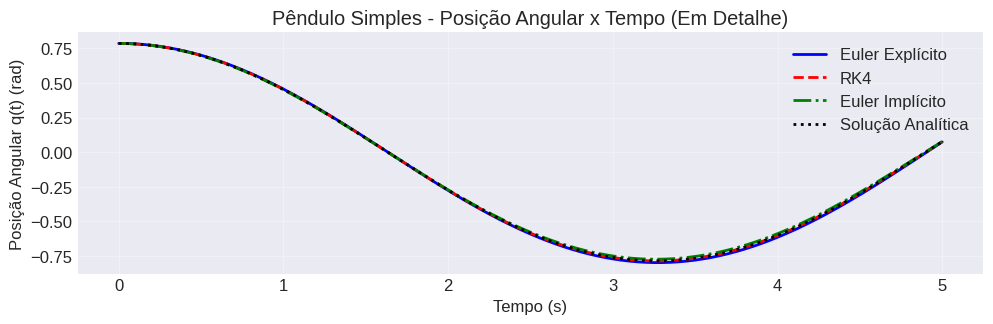

In [61]:
plt.subplot(2, 1, 2)
zoom_idx = t <= 5
plt.plot(t[zoom_idx], u_euler[zoom_idx,0]   , 'b-' , label='Euler Explícito'  , linewidth=2)
plt.plot(t[zoom_idx], u_rk4[zoom_idx,0]     , 'r--', label='RK4'              , linewidth=2)
plt.plot(t[zoom_idx], u_implicit[zoom_idx,0], 'g-.', label='Euler Implícito'  , linewidth=2)
plt.plot(t[zoom_idx], q_ref[zoom_idx]       , 'k:' , label='Solução Analítica', linewidth=2)
plt.xlabel('Tempo (s)')
plt.ylabel('Posição Angular q(t) (rad)')
plt.title('Pêndulo Simples - Posição Angular x Tempo (Em Detalhe)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Tarefa 1.3 - Análise de Ordem de Convergência dos Métodos Numéricos Implementados

In [62]:
def empirical_convergence_order(method):
    # Diferentes tamanhos de passo (de tempo)
    h_values = np.array([0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625])

    # Tempo final observado é fixo, para uma comparação justa!
    T = 10.0
    t_span = [0, T]
    
    # Inicialização de uma 'list' para armazenar o erro correspondente a cada tamanho de passo
    errors = []

    for h in h_values:
        # Aplicar método com tamanho de passo atual
        t, u = method(pendulum_system, u0, t_span, h)

        # Resgatar solução de referência (nos mesmos pontos da solução aproximada)
        q_ref, _ = RefSolution(q0, t)

        # Erro dado pelo ponto de maior discrepância entre as soluções
        error_h = np.max(np.abs(u[:,0]) - q_ref)
        errors.append(error_h)

    errors = np.array(errors)

    # Calcular ordem de convergência
    rates = []
    for i in range(len(errors)-1):
        rate = np.log(errors[i]/errors[i+1]) / np.log(h_values[i]/h_values[i+1])
        rates.append(rate)
        
    return h_values, errors, rates

In [63]:
h_values, err_euler   , rates_euler    = empirical_convergence_order(euler_explicit)
h_values, err_rk4     , rates_rk4      = empirical_convergence_order(rk4)
h_values, err_implicit, rates_implicit = empirical_convergence_order(euler_implicit)

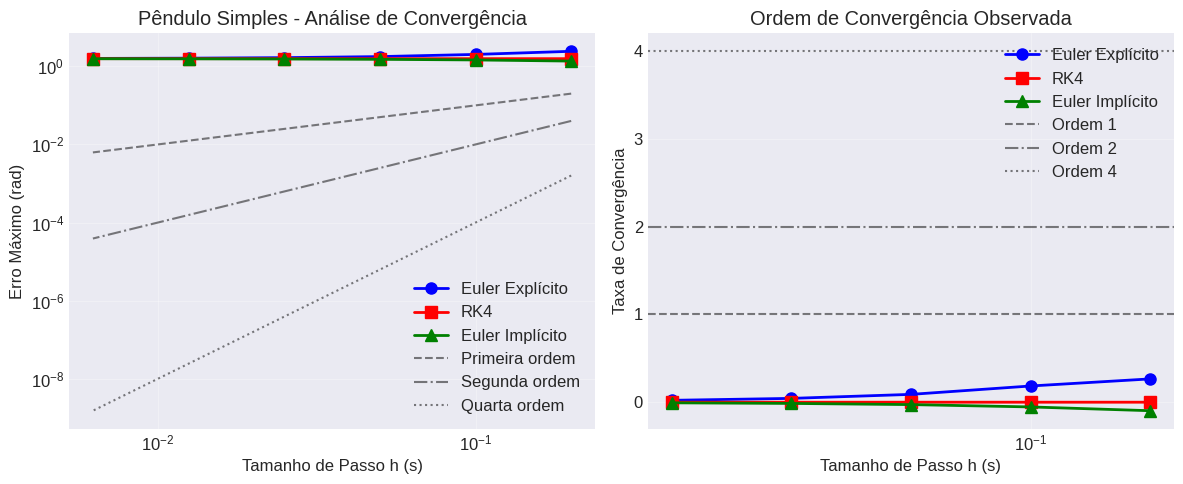

Resultados da Análise de Convergência:
Método               Ordem Média     Ordem Esperada 
--------------------------------------------------
Euler Explícito      0.12                  1
RK4                  -0.00                 4
Euler Implícito      -0.04                 1


In [73]:
# Plotar convergência dos métodos
plt.figure(figsize=(12, 5))

# Erro vs Tamanho de Passo (Temporal)
plt.subplot(1, 2, 1)
plt.loglog(h_values, err_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.loglog(h_values, err_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.loglog(h_values, err_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)

# Linhas de referência
plt.loglog(h_values, h_values   , 'k--', alpha=0.5, label='Primeira ordem')
plt.loglog(h_values, h_values**2, 'k-.', alpha=0.5, label='Segunda ordem')
plt.loglog(h_values, h_values**4, 'k:' , alpha=0.5, label='Quarta ordem')

plt.xlabel('Tamanho de Passo h (s)')
plt.ylabel('Erro Máximo (rad)')
plt.title('Pêndulo Simples - Análise de Convergência')
plt.legend()
plt.grid(True, alpha=0.3)

# Taxas de convergência
plt.subplot(1, 2, 2)
plt.plot(h_values[:-1], rates_euler   , 'bo-', label='Euler Explícito', linewidth=2, markersize=8)
plt.plot(h_values[:-1], rates_rk4     , 'rs-', label='RK4'            , linewidth=2, markersize=8)
plt.plot(h_values[:-1], rates_implicit, 'g^-', label='Euler Implícito', linewidth=2, markersize=8)
plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='Ordem 1')
plt.axhline(y=2, color='k', linestyle='-.', alpha=0.5, label='Ordem 2')
plt.axhline(y=4, color='k', linestyle=':' , alpha=0.5, label='Ordem 4')
plt.xlabel('Tamanho de Passo h (s)')
plt.ylabel('Taxa de Convergência')
plt.title('Ordem de Convergência Observada')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log')

plt.tight_layout()
plt.show()

# Imprimir taxas de convergência
print("Resultados da Análise de Convergência:")
print("="*50)
print(f"{'Método':<20} {'Ordem Média':<15} {'Ordem Esperada':<15}")
print("-"*50)
print(f"{'Euler Explícito':<20} {np.mean(rates_euler):.2f}                  {1}")
print(f"{'RK4':<20} {np.mean(rates_rk4):.2f}                 {4}")
print(f"{'Euler Implícito':<20} {np.mean(rates_implicit):.2f}                 {1}")

#### Tarefa 1.4 - Retrato de Fase (Velocidade Angular $\times$ Posição Angular)

Retrato de fase da solução de referência

Retrato de fase da solução fornecida pelo método de Euler explícito

Retrato de fase da solução fornecida pelo método RK4 

Retrato de fase da solução fornecida pelo método de Euler Implícito

### Tarefa 2 - Pêndulo Duplo 